## Generating a Graph Based on Los Angeles County Fire Hazard Severity Zones
In this notebook, we explain our approach of converting [Los Angeles County Fire Hazard Severity Zones](https://www.youtube.com/watch?v=WEBx_9Or88c), which classifies 20–200 acre zones located within the county as "moderate," "high," or "very high" risk, into an undirected graph that we can perform the quantum graph coloring algorithm on to minimize the risk to Travelers' portfolios. This real data shows how this algorithm, which has a quantum advantage, can be used in a real-world use case to minimize the risk to Travelers.

One of the Travelers mottos is "Remarkable Things Happen When People Care," and we focused on this company motto as we worked on our project. Investing in the professional development of quantum algorithms such as this one can reduce risk in Travelers' portfolios and allow the company to more strongly help its customers in the case of a catastrophe.

This notebook explains how we imported and processed our data; for a technical description of our quantum algorithm, see [mis.ipynb](mis.ipynb).

In [2]:
import math
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import json
import gcol
import random
import os

This block of code unpacks the [JSON file](https://hub.arcgis.com/datasets/lacounty::fire-hazard-severity-zones/api) and converts polygon vertices into more usable average coordinates. `idx` contains the index/id of the zone and `feature` contains all of its data. The attributes section contains the hazard level, although if configured differently the JSON file could include more attributes. The geometry feature contains the polygon verticies. The loop collects all of the different points in geometry (which is stored under the "rings" subcategory in the json file), goes through them and finds the average of all points for that zone. The `centroids` dictionary then stores the hazard level and the coordinates as a tuple. 

Finally, we take a random sample of a certain amount of the fire hazard zones, which can be considered to be the subset of zones with Travelers customers in them. In reality, the fire hazard dataset could be linked to some internal database from Travelers that lists certain zones their customers live in.

In [9]:
with open("LACountyFireHazardLevel.json") as file:
    full_data = json.load(file)

centroids = {}

for idx, feature in enumerate(full_data['features']):
    attributes = feature.get('attributes', {})
    geometry = feature.get('geometry', {})

    if 'rings' in geometry and geometry['rings']:
        points = geometry['rings'][0]
        num_points = len(points)

        avg_lon = sum(p[0] for p in points) / num_points
        avg_lat = sum(p[1] for p in points) / num_points
        hazard_level = attributes.get('HAZ_CLASS', 'Unknown')

        centroids[idx] = (hazard_level, avg_lat, avg_lon)

random.seed(3)
indices = random.sample(sorted(centroids.keys()), 50)
sample = {}
for idx in indices:
    sample[len(sample)+1] = centroids[idx]

To get the distance between two zones with the same hazard level categorization, our model uses a simple Euclidean distance calculation using their latitude and longitude coordinates. In reality, the number of Travelers customers in each zone could also potentially be linked to how the distance between zones is calculated. We then take a value $\epsilon$, which we have arbitrarily set to $0.2$ for the sake of example, which represents the maximum distance the graph coloring property should be enforced on. In other words, any two zones that are less than $\epsilon$ apart must be in different portfolio categories to best minimize the risk to Travelers.

In [10]:
def euclidean(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
epsilon = 0.2

We then create a dictionary-of-dictionary-of-dictionaries `distance_matrix`, where `distance_matrix[hazard_level][u][v]` represents the Euclidean distance of nodes `u` and `v` with hazard level `hazard_level` in the graph. This allows us to set up our three undirected graphs based on hazard level designation.

In [11]:
distance_matrix = {}
for id1, attributes1 in sample.items():
    hazard_level1 = attributes1[0]
    coord1 = (attributes1[1], attributes1[2])
    if hazard_level1 not in distance_matrix.keys():
        distance_matrix[hazard_level1] = {}
    distance_matrix[hazard_level1][id1] = {}
    for id2, attributes2 in sample.items():
        hazard_level2 = attributes2[0]
        coord2 = (attributes2[1], attributes2[2])
        if id1 != id2 and hazard_level1 == hazard_level2:
            distance_matrix[hazard_level1][id1][id2] = euclidean(coord1, coord2)

We then create our three graphs `moderateGraph`, `highGraph`, and `veryHighGraph` as dictionaries-of-dictionaries where `graph[u][v]` is $1$ if nodes `u` and `v` are closer than $\epsilon$ and $0$ if they are farther.

In [12]:
moderateGraph = {}
for id1 in distance_matrix["Moderate"].keys():
    for id2 in distance_matrix["Moderate"][id1].keys():
        dist = distance_matrix["Moderate"][id1][id2]
        if id1 not in moderateGraph.keys():
                moderateGraph[id1] = {}
        if dist < epsilon:
            if id2 not in moderateGraph[id1].keys():
                moderateGraph[id1][id2] = 1
        
highGraph = {}
for id1 in distance_matrix["High"].keys():
    for id2 in distance_matrix["High"][id1].keys():
        dist = distance_matrix["High"][id1][id2]
        if id1 not in highGraph.keys():
            highGraph[id1] = {}
        if dist < epsilon:
            if id2 not in highGraph[id1].keys():
                highGraph[id1][id2] = 1

veryHighGraph = {}
for id1 in distance_matrix["Very High"].keys():
    for id2 in distance_matrix["Very High"][id1].keys():
        dist = distance_matrix["Very High"][id1][id2]
        if id1 not in veryHighGraph.keys():
            veryHighGraph[id1] = {}
        if dist < epsilon:
            if id2 not in veryHighGraph[id1].keys():
                veryHighGraph[id1][id2] = 1

To pass our graph into our quantum algorithm, we need a list of positive XY-coordinates which will be represented as a list of positions of Rydberg atoms in the lattice. For this example, we employ a simple random algorithm to find a set of working positions. It should be noted that these specific positions are arbitrary; the distance between two nodes just needs to be less than 7.5 (our blockade radius, as defined in [mis.ipynb](mis.ipynb)) if the graph coloring property should be respected between them and greater than 7.5 if not. All of these distances are in $\text{μm}$ as they correspond to the positions of the Rydberg atoms in our lattice.

In [7]:
def generate_positions(graph, bound=50, maxiters=1000):
    positions = {}
    placed_nodes = set()

    first_node = list(graph.keys())[0]
    positions[first_node] = (0, 0)
    placed_nodes.add(first_node)

    def find_position(node):
        candidate_position = None
        valid_position = False
        for _ in range(maxiters):
            x = random.uniform(-bound, bound)
            y = random.uniform(-bound, bound)
            candidate_position = (x, y)
            valid_position = True
            for neighbor in placed_nodes:
                if neighbor in graph[node]:
                    dist = euclidean(candidate_position, positions[neighbor])
                    if dist > 7.5 or candidate_position in positions.values():
                        valid_position = False
                        break
                else:
                    dist = euclidean(candidate_position, positions[neighbor])
                    if dist <= 7.5 or candidate_position in positions.values():
                        valid_position = False
                        break
            if valid_position:
                return candidate_position
        if not valid_position:
            raise ValueError('Could not find solution')

    for node in graph:
        if node not in placed_nodes:
            new_position = find_position(node)
            positions[node] = new_position
            placed_nodes.add(node)

    min_x = min(x for x, _ in positions.values())
    min_y = min(y for _, y in positions.values())

    if min_x < 0 or min_y < 0:
        shift_x = abs(min_x) if min_x < 0 else 0
        shift_y = abs(min_y) if min_y < 0 else 0
        positions = {node: (x + shift_x, y + shift_y) for node, (x, y) in positions.items()}

    return [(float(x),float(y)) for (x,y) in positions.values()]

Finally, we generate the positions for the graph we would like to pass into our quantum algorithm; for the sake of example, we pass in `highGraph`. The list of positions is pickled and dumped into this directory, where it can be retrieved by our Julia program in [mis.ipynb](mis.ipynb) so the quantum algorithm can be executed.

In [11]:
positions = generate_positions(highGraph)
if os.path.exists("graph.pickle"):
    os.remove("graph.pickle")
with open("graph.pickle", "wb") as file:
    pickle.dump(positions, file)

For comparison, we use a purely classical exponential-time graph coloring algorithm defined in the `gcol` library. We can compare the output of this graph to the output of our quantum algorithm in [output.pdf](output.pdf) and see that they match. More technical details about our quantum algorithm can be found in [mis.ipynb](mis.ipynb).

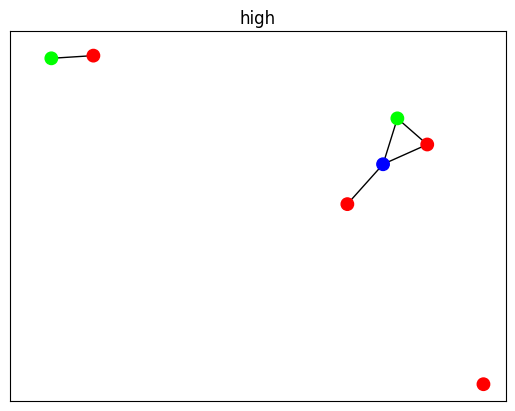

In [13]:
HG = nx.Graph(highGraph)
cHG = gcol.node_coloring(HG, opt_alg=1)

plt.title("high")
nx.draw_networkx(HG,
                 pos=nx.spring_layout(HG, seed=3),
                 node_color=gcol.get_node_colors(HG, cHG, gcol.colorful),
                 with_labels=False,
                 node_size=80)
plt.show()

Of course, the classical algorithm above is too slow to be run in large, real-world applications like ones involving Travelers' portfolio. However, the quantum algorithm can be run for very large use cases given strong enough neutral-atom quantum hardware. [This paper](https://doi.org/10.1109/ECICE59523.2023.10383156) from 2023 shows that QuEra's Aquila can successfully find the MIS for at least eight qubits and less than fifty qubits. While we didn't have time to test our algorithm on the quantum hardware ourselves, as the hardware improves, our quantum approach will very likely become more viable for real-world use cases like the large datasets of Travelers customers.

Our hope is that our preliminary research and results show that the quantum approach of using MIS to find graph coloring can potentially be used to help Travelers minimize risk and fulfill their company motto by being more able to respond to their customers when a catastrophe does strike. We sincerely thank Travelers and Capgemini for this challenge; we greatly enjoyed the opportunity to conduct some market research and try out and think about a quantum algorithm that can actually be used for the heavy datasets of the real-world!